<a href="https://colab.research.google.com/github/stupidbutsmart/DELE-CA1/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
  b {
    color: red;
  }
</style>

## Section A CA1 CNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [2]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import gc
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Conv2D, MaxPooling2D , UpSampling2D, Cropping2D, ReLU, BatchNormalization, Dropout, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1 , l2
from tensorflow.keras.metrics import Precision , Recall
from sklearn.model_selection import RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

### Creating UDFs to aid workflow

Before i start, i want to create some functions that can help me with my work.

basic functions like:
1. create model function
2. autoencoder function
3. data processing functions

etc.

This can help modularize my code (especially since im working with 2 models) and make it easier for future collaborater to understand

In [3]:
DATASET_PATH = './datasets/'
STORED_DATA ='./stored_data/'
def get_greyscale_data(data_type , size):
  targets = [ target for target in os.listdir(DATASET_PATH + data_type)]

  rows = []
  for target in targets: 
    for file_name in os.listdir(os.path.join(DATASET_PATH , data_type ,  target)):
      # greyscale 
      img = image.load_img(os.path.join(DATASET_PATH , data_type, target , file_name ) ,color_mode='grayscale' , target_size=size)
      img = image.img_to_array(img) / 255.0 # divide by 255 to normalize it
      
      record = {'sequence' : img}
      for t in targets:
        record[t] = 1 if t == target else 0

      rows.append(record)

  return pd.DataFrame(rows , columns=['sequence'] + targets)



### Data Cleaning and Exploration

I plan to do manual inspection to clean my data, therfore cleaning will be done before importing

##### What i Found

1. There are some **duplicated images**, we will remove using **.drop_duplicates()** when we eventually import it

##### Test:

1. **Pumpkin** Folder Contains only **Tomatoes**
2. **Tomato** Folder Contains only **Pumpkins**
3. The folders are misnamed. For example **Bottle_Gourd and Cucumbers** should be **Cucumbers and Bottle Gourd**

So i just changed the names of those folders

##### Train:

1. **Beans** Contains some **Carrots**

I will move them into the **carrots** folder, incase of duplicates, they will be dropped later.

##### Validation:

Looks about as clean as it can get

In [44]:
## NOTE
## get_greyscale_data() takes awhile to run
## below there is a function that builds the DF from ./stored_data
## run if ./stored_data was not provided, otherwise run cell with build_data() below
train_data_23 = get_greyscale_data('train' , (23 , 23))
## repeat for test and validation
test_data_23 = get_greyscale_data('test' , (23 , 23))
validation_data_23 = get_greyscale_data('validation' , (23 , 23))

# 101
train_data_101 = get_greyscale_data('train' , (101 , 101))
test_data_101 = get_greyscale_data('test' , (101 , 101))
validation_data_101 = get_greyscale_data('validation' , (101 , 101))

In [45]:
# Removing Duplicates
def remove_dupes(data):
  # Since we cannot hash lists, we need a string equivalent
  # This allows me to use the drop_duplicate function
  data['sequence_str'] = data['sequence'].apply(lambda x: str(x))
  data = data.drop_duplicates(subset=[col for col in data.columns if col != 'sequence'])
  data = data.drop(columns=['sequence_str'])
  return data


In [46]:
test_data_23 = remove_dupes(test_data_23)
train_data_23 = remove_dupes(train_data_23)
validation_data_23 = remove_dupes(validation_data_23)

test_data_101 = remove_dupes(test_data_101)
train_data_101 = remove_dupes(train_data_101)
validation_data_101 = remove_dupes(validation_data_101)

In order to save computional time, we will save the data, allowing us to build our df from it.

We are using json format, as integrates seamlessly with my **sequence** column

In [47]:
#23 
train_data_23.to_json(os.path.join(STORED_DATA , 'train_23.json') , orient='records')
test_data_23.to_json(os.path.join(STORED_DATA , 'test_23.json') , orient='records')
validation_data_23.to_json(os.path.join(STORED_DATA , 'validation_23.json') , orient='records')
#101
train_data_101.to_json(os.path.join(STORED_DATA , 'train_101.json') , orient='records')
test_data_101.to_json(os.path.join(STORED_DATA , 'test_101.json') , orient='records')
validation_data_101.to_json(os.path.join(STORED_DATA , 'validation_101.json') , orient='records')

With our data exported, we can reimport it 

In [4]:
# 23
train_data_23 = pd.read_json(os.path.join(STORED_DATA , 'train_23.json'))
test_data_23 = pd.read_json(os.path.join(STORED_DATA , 'test_23.json'))
validation_data_23 = pd.read_json(os.path.join(STORED_DATA , 'validation_23.json'))


In [5]:

# 101
train_data_101 = pd.read_json(os.path.join(STORED_DATA , 'train_101.json'))
test_data_101 = pd.read_json(os.path.join(STORED_DATA , 'test_101.json'))
validation_data_101 = pd.read_json(os.path.join(STORED_DATA , 'validation_101.json'))

We can recontruct it and plot it using matplotlib 

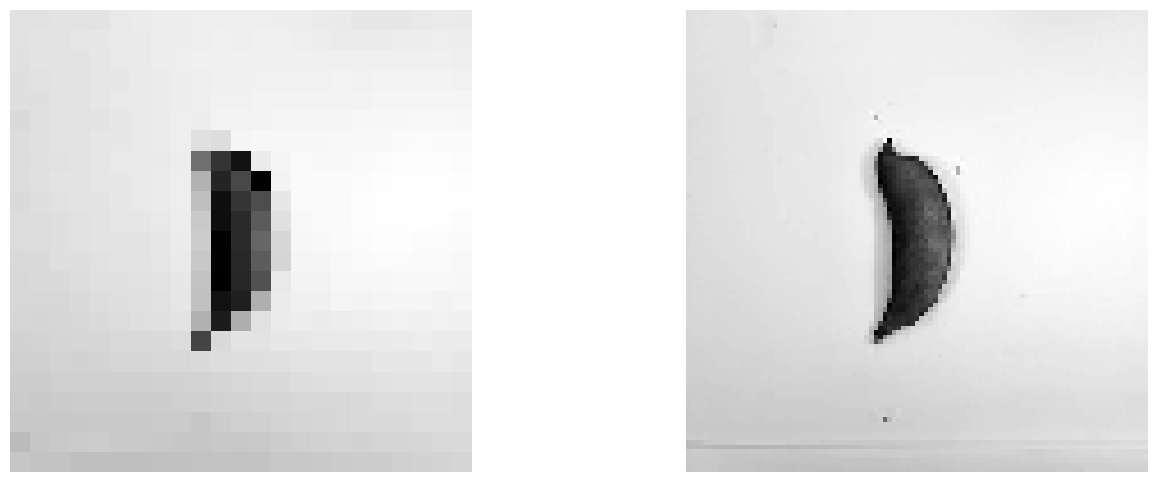

In [6]:
fig , ax = plt.subplots(1 , 2, figsize=(16 , 6))
ax[0].imshow(train_data_23['sequence'].iloc[0] , cmap='gray')
ax[0].axis('off')
ax[1].imshow(train_data_101['sequence'].iloc[0] , cmap='gray')
ax[1].axis('off')
plt.show()

##### Comparing it to its real img counterpart
<style>
.two_col_row {
  display: grid;
  grid-template-columns: 1fr 1fr; /* Two equal columns */
  gap: 20px; /* Space between items */
  padding: 20px
}

img {
  height: auto;
  width: 100%;
}



  </style>
<div class='two_col_row'>
  <img src='./markdown/bean_1_imap.png'>
  <img src='./markdown/bean_1_original.jpg'>
</div>


looks like a very nice bean

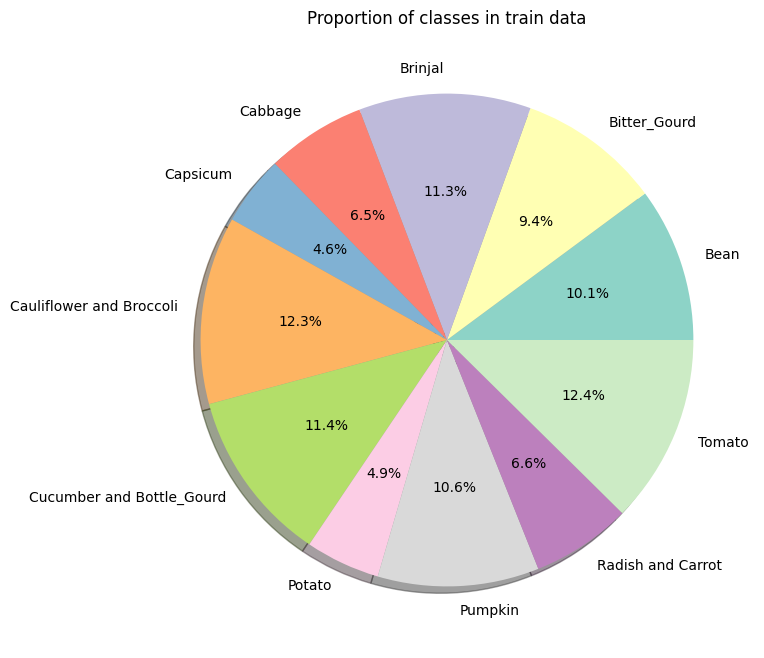

In [8]:
# Comparing classes
# Both classes are the same for 23 and 101 datasets

counts = []
for col in train_data_23.columns[1:]:
  amount_of_class = train_data_23[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=train_data_23.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in train data')
plt.show()

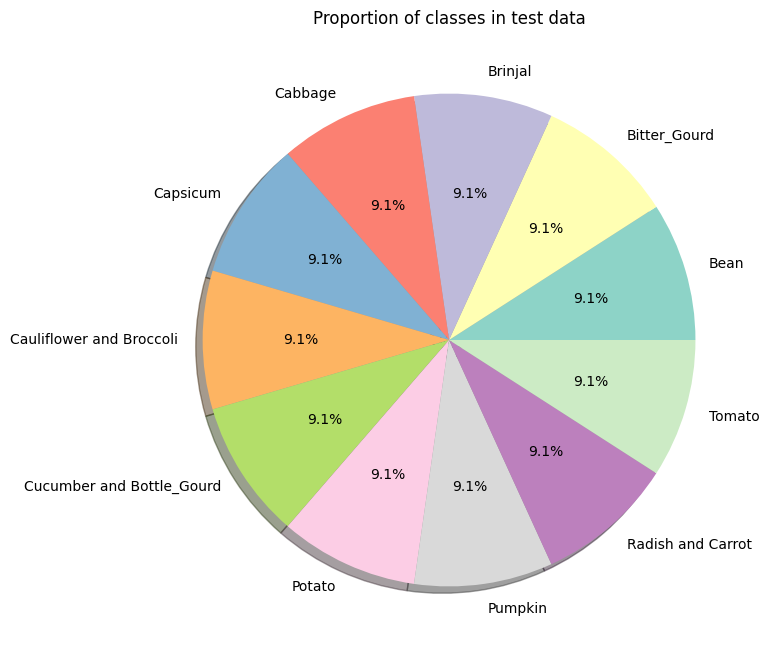

In [ ]:
counts = []
for col in test_data_23.columns[1:]:
  amount_of_class = test_data_23[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=test_data_23.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in test data')
plt.show()

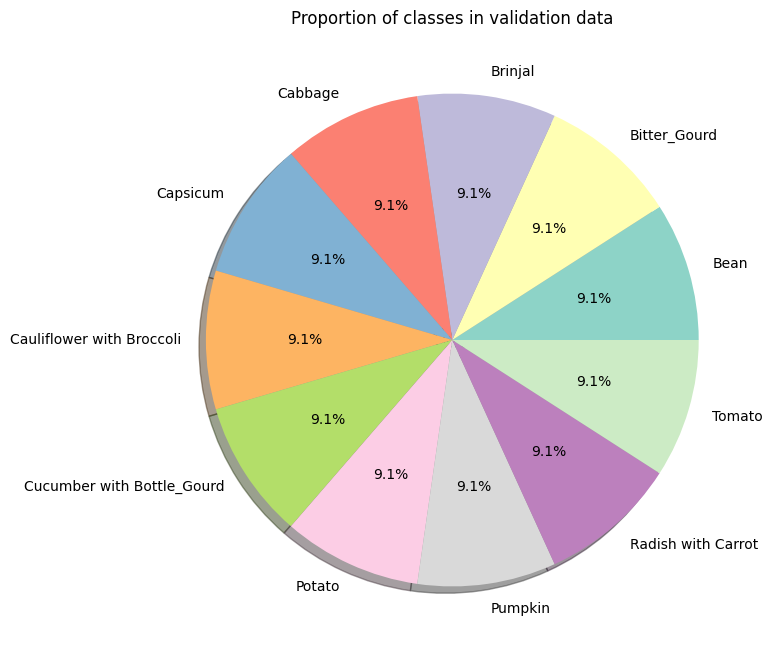

In [ ]:
counts = []
for col in validation_data_23.columns[1:]:
  amount_of_class = validation_data_23[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=validation_data_23.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in validation data')
plt.show()

This shows that the train data has **unbalanced features** while the test and validation is **perfectly balanced**


This suggests that i should use metrics like recall when training

I can also attempt to use class weights when training to balance out the imbalanced data

##### Metrics

Due to the class imbalances, it is still a good idea to use a different metric from accuracy. 

**Why?**

Even with the class weights, the model might still learn to **prioritize the smaller classes** to minimize loss. 


I will create a custom callback for me to monitor the **f1-score**

This will be the main area of focus for my cnn

In [29]:
# 23
X_train_23 = np.asarray(np.stack(train_data_23['sequence']) , dtype=np.float32)
y_train_23 = np.asarray(train_data_23.drop(columns=['sequence']).values.astype(float), dtype=np.float32)

X_test_23 = np.stack(test_data_23['sequence'])
y_test_23 = test_data_23.drop(columns=['sequence']).values

X_validation_23 = np.asarray(np.stack(validation_data_23['sequence']), dtype=np.float32)
y_validation_23 = np.asarray(validation_data_23.drop(columns=['sequence']).values.astype(float) , dtype = np.float32)


# 101
X_train_101 = np.asarray(np.stack(train_data_101['sequence']) , dtype=np.float32)
y_train_101 = np.asarray(train_data_101.drop(columns=['sequence']).values.astype(float), dtype=np.float32)

X_test_101 = np.stack(test_data_101['sequence'])
y_test_101 = test_data_101.drop(columns=['sequence']).values

X_validation_101 = np.asarray(np.stack(validation_data_101['sequence']), dtype=np.float32)
y_validation_101 = np.asarray(validation_data_101.drop(columns=['sequence']).values.astype(float) , dtype = np.float32)

In [7]:
## Generating class weights
## These labels can be used for both sizes
# used only before data aug

y_train_labels = np.argmax(y_train_23, axis=1)
class_labels = np.unique(y_train_labels)
class_weights = compute_class_weight(
  class_weight='balanced', 
  classes=class_labels,
  y=y_train_labels 
)

class_weights_dict = dict(enumerate(class_weights))

##### Is my data enough? 

One easy way to check if to create a very simple and generic model. We can also use this as our **baseline model**

We can train the data on the baseline model and **compare the val and train f1 scores**

**Ideally** we should see both the train and the val flatline

In [27]:

# Creating metric for f1 score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        precision = logs['precision']
        recall = logs['recall']
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        logs['f1_score'] = f1_score

        precision = logs['val_precision']
        recall = logs['val_recall']
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        logs['val_f1_score'] = f1_score

In [28]:
def create_baseline_model():
  baseline_model = Sequential([
    Conv2D(32, kernel_size=(5 , 5), padding='same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D((3 , 3), padding='same'),
    
    Conv2D(64, kernel_size=(5 , 5), padding='same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D((3 , 3), padding='same'),
    
    Conv2D(128, kernel_size=(5 , 5), padding='same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D((3 , 3), padding='same'),

    Dropout(0.7),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(11 , activation='softmax')
  ])

  baseline_model.compile(loss='categorical_crossentropy' , optimizer=Adam(learning_rate=1e-4) , metrics=[
    Precision(name='precision'), Recall(name='recall'), 'accuracy'
  ])
  return baseline_model

Training on 0.25 of data size 23
Training on 0.5 of data size 23
Training on 0.75 of data size 23
Training on 1 of data size 23
Training on 0.25 of data size 101
Training on 0.5 of data size 101
Training on 0.75 of data size 101
Training on 1 of data size 101


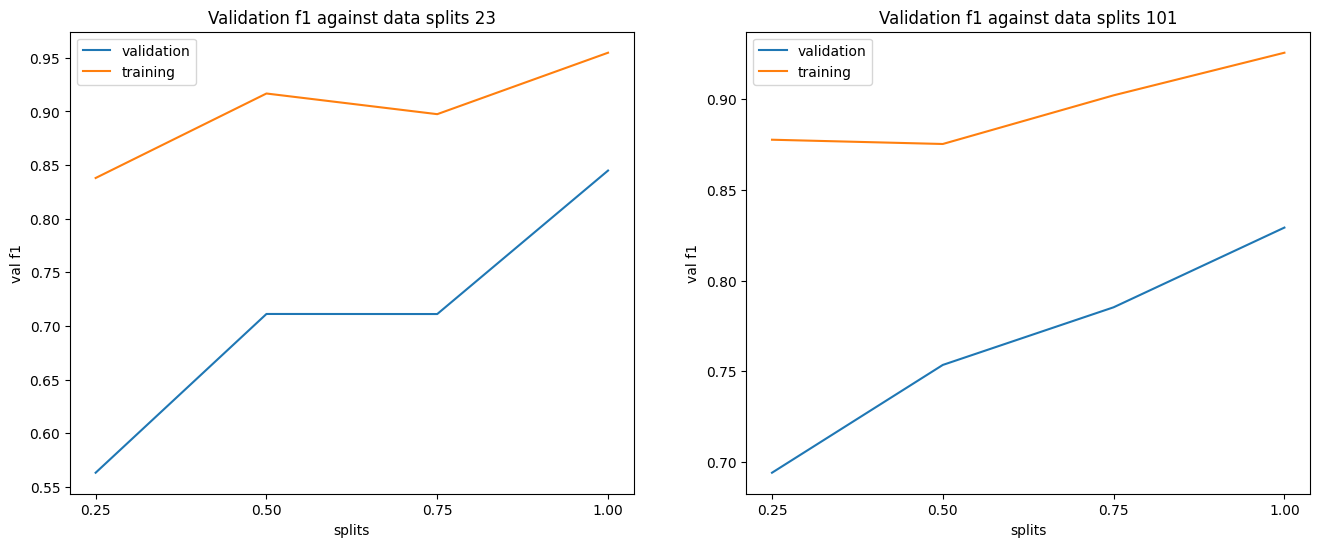

In [17]:
# Training on splits in order to see if the f1 score plateaus 
splits = [0.25, 0.5 , 0.75 , 1] 

fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))

for i in range(2):
  last_4_val_f1 = []
  last_4_f1 = []
  for split in splits:
    print(f'Training on {split} of data size {23 if i == 0 else 101}')

    # data handling
    if i == 0: # 23
      if split != 1:
        X_train_split , _ ,y_train_split , _ = train_test_split(X_train_23 , y_train_23, random_state=42 , train_size=split , stratify=y_train_23)
        X_train_split = np.asarray(X_train_split, dtype=np.float32)
        y_train_split = np.asarray(y_train_split, dtype=np.float32)
      else:
        X_train_split = np.asarray(X_train_23, dtype=np.float32)
        y_train_split = np.asarray(y_train_23, dtype=np.float32)

      X_validation = np.asarray(X_validation_23, dtype=np.float32)
      y_validation = np.asarray(y_validation_23, dtype=np.float32)
    else: # 101
      if split != 1:
        X_train_split , _ ,y_train_split , _ = train_test_split(X_train_101 , y_train_101, random_state=42 , train_size=split , stratify=y_train_101)
        X_train_split = np.asarray(X_train_split, dtype=np.float32)
        y_train_split = np.asarray(y_train_split, dtype=np.float32)
      else:
        X_train_split = np.asarray(X_train_101, dtype=np.float32)
        y_train_split = np.asarray(y_train_101, dtype=np.float32)

      X_validation = np.asarray(X_validation_101, dtype=np.float32)
      y_validation = np.asarray(y_validation_101, dtype=np.float32)
      

    early_stop = EarlyStopping(patience=10 , monitor='val_f1_score' ,restore_best_weights=True , mode='max') 
    baseline_model = create_baseline_model()
    base_model_fit_results = baseline_model.fit(X_train_split, y_train_split,
                       epochs=200,
                       batch_size=32 ,
                       validation_data=(X_validation , y_validation),
                       verbose=0,
                       class_weight=class_weights_dict,
                       callbacks=[F1ScoreCallback() , early_stop]
    )

    last_4_val_f1.append(np.max(base_model_fit_results.history['val_f1_score']))
    last_4_f1.append(np.max(base_model_fit_results.history['f1_score']))

  # Plotting
  ax[i].plot(splits , last_4_val_f1, label='validation')
  ax[i].plot(splits , last_4_f1 , label='training')
  ax[i].set_title(f'Validation f1 against data splits {23 if i == 0 else 101}')
  ax[i].set_xlabel('splits')
  ax[i].set_ylabel('val f1')
  ax[i].legend()
  ax[i].set_xticks(splits)
    
plt.show()

It quite clearly shows that the validation and train data can still increase together. (their lines are not parallel)

However it does seem like their performance is about to peak already, suggesting maybe a small increase (0.2 or 0.25) should be enough for it.

In [9]:
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    zoom_range=[0.8 , 1.2],
    horizontal_flip=False,
    fill_mode='nearest'
)

In [10]:
X_23 = np.stack(train_data_23["sequence"].values)  
y_23 = np.stack(train_data_23.drop(columns=['sequence']).values)  

In [11]:
augment_size = int(0.2 * len(X_23))

X_aug = np.zeros((augment_size,) + X_23.shape[1:])
y_aug = np.zeros((augment_size,) + y_23.shape[1:])

for i in range(augment_size):
    # Get a random index
    idx = np.random.randint(0, len(X_23))
    img = X_23[idx].reshape((1,) + X_23[idx].shape)
    aug_img = next(datagen.flow(img, batch_size=1))[0]
    X_aug[i] = aug_img
    y_aug[i] = y_23[idx]

# Combining the data
X_train_23_augmented = np.concatenate([X_23, X_aug])
y_train_23_augmented = np.concatenate([y_23, y_aug])

X_train_23_augmented = np.asarray(X_train_23_augmented, dtype=np.float32)
y_train_23_augmented = np.asarray(y_train_23_augmented, dtype=np.float32)

In [12]:
# Ensuring data was created
print(f"Original training data shape: {X_23.shape}")
print(f"Augmented training data shape: {X_train_23_augmented.shape}")

Original training data shape: (7693, 23, 23, 1)
Augmented training data shape: (9231, 23, 23, 1)


In [13]:
# repeat for 101
X_101 = np.stack(train_data_101["sequence"].values)  
y_101 = np.stack(train_data_101.drop(columns=['sequence']).values)  
X_aug = np.zeros((augment_size,) + X_101.shape[1:])
y_aug = np.zeros((augment_size,) + y_101.shape[1:])

for i in range(augment_size):
    # Get a random index
    idx = np.random.randint(0, len(X_101))
    img = X_101[idx].reshape((1,) + X_101[idx].shape)
    aug_img = next(datagen.flow(img, batch_size=1))[0]
    X_aug[i] = aug_img
    y_aug[i] = y_101[idx]

# Combining the data
X_train_101_augmented = np.concatenate([X_101, X_aug])
y_train_101_augmented = np.concatenate([y_101, y_aug])

X_train_101_augmented = np.asarray(X_train_101_augmented, dtype=np.float32)
y_train_101_augmented = np.asarray(y_train_101_augmented, dtype=np.float32)

In [14]:
# Ensuring data was created
print(f"Original training data shape: {X_101.shape}")
print(f"Augmented training data shape: {X_train_101_augmented.shape}")

Original training data shape: (7606, 101, 101, 1)
Augmented training data shape: (9144, 101, 101, 1)


In [ ]:
## Export this augmented data
np.save(os.path.join(STORED_DATA , 'cleaned_data', 'X_train_101_cleaned') , X_train_101_augmented)
np.save(os.path.join(STORED_DATA , 'cleaned_data', 'y_train_101_cleaned') , y_train_101_augmented)

np.save(os.path.join(STORED_DATA , 'cleaned_data', 'X_train_23_cleaned') , X_train_23_augmented)
np.save(os.path.join(STORED_DATA , 'cleaned_data', 'y_train_23_cleaned') , y_train_23_augmented)

In [7]:
# Then load the data
X_train_101_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'X_train_101_cleaned.npy'))
y_train_101_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'y_train_101_cleaned.npy'))

X_train_23_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'X_train_23_cleaned.npy'))
y_train_23_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'y_train_23_cleaned.npy'))

Create new y classes for the new datasets (random sampled data aug)

In [8]:
y_train_labels_23 = np.argmax(y_train_23_augmented, axis=1)
class_labels_23 = np.unique(y_train_labels_23)
class_weights_23 = compute_class_weight(
  class_weight='balanced', 
  classes=class_labels_23,
  y=y_train_labels_23
)

class_weights_dict_23 = dict(enumerate(class_weights_23))

In [9]:
y_train_labels_101 = np.argmax(y_train_101_augmented, axis=1)
class_labels_101 = np.unique(y_train_labels_101)
class_weights_101 = compute_class_weight(
  class_weight='balanced', 
  classes=class_labels_101,
  y=y_train_labels_101
)

class_weights_dict_101 = dict(enumerate(class_weights_101))

##### Predicting on Baseline Model

Epoch 1/100
289/289 [==============================] - 6s 16ms/step - loss: 3.4446 - precision: 0.1224 - recall: 0.0434 - accuracy: 0.1174 - val_loss: 2.4586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.1268 - f1_score: 0.0641 - val_f1_score: 0.0000e+00
Epoch 2/100
289/289 [==============================] - 3s 12ms/step - loss: 2.6655 - precision: 0.1695 - recall: 0.0186 - accuracy: 0.1336 - val_loss: 2.2778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.1964 - f1_score: 0.0336 - val_f1_score: 0.0000e+00
Epoch 3/100
289/289 [==============================] - 3s 11ms/step - loss: 2.5001 - precision: 0.2015 - recall: 0.0118 - accuracy: 0.1455 - val_loss: 2.2204 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.2627 - f1_score: 0.0223 - val_f1_score: 0.0000e+00
Epoch 4/100
289/289 [==============================] - 3s 11ms/step - loss: 2.4265 - precision: 0.2558 - recall: 0.0107 - accuracy: 0.1536 - val_loss: 2.2033 - 

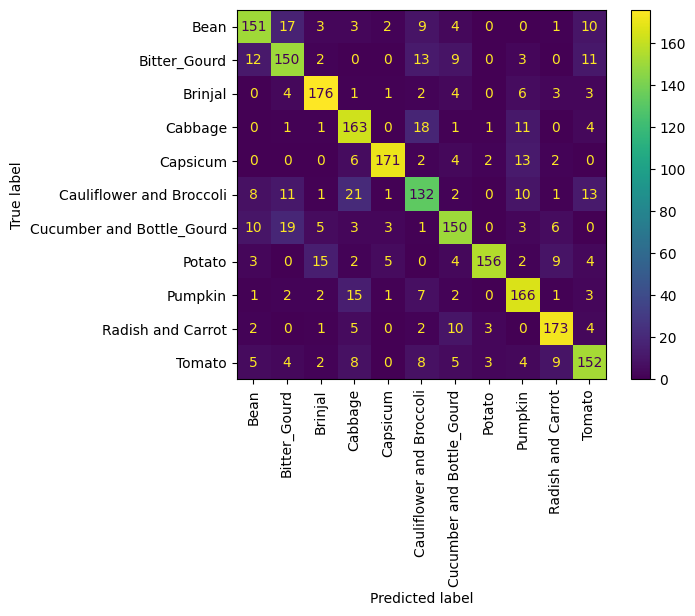

In [27]:
baseline_model_23 = create_baseline_model()
baseline_model_23.fit(
  X_train_23_augmented, y_train_23_augmented,
  epochs = 100,
  validation_data=(X_validation_23 , y_validation_23),
  verbose=1,
  batch_size=32,
  class_weight=class_weights_dict_23,
  callbacks=[F1ScoreCallback() ,EarlyStopping(patience=8, monitor='val_f1_score' , restore_best_weights=True , mode='max')]
)

y_pred = baseline_model_23.predict(X_test_23)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_23, axis=1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

Epoch 1/100
286/286 [==============================] - 7s 21ms/step - loss: 2.1530 - precision: 0.4353 - recall: 0.0416 - accuracy: 0.2414 - val_loss: 3.3016 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0805 - f1_score: 0.0759 - val_f1_score: 0.0000e+00
Epoch 2/100
286/286 [==============================] - 6s 21ms/step - loss: 1.7878 - precision: 0.6584 - recall: 0.1043 - accuracy: 0.3754 - val_loss: 2.5194 - val_precision: 0.6089 - val_recall: 0.0569 - val_accuracy: 0.2049 - f1_score: 0.1801 - val_f1_score: 0.1041
Epoch 3/100
286/286 [==============================] - 6s 20ms/step - loss: 1.6011 - precision: 0.6879 - recall: 0.1692 - accuracy: 0.4393 - val_loss: 1.3647 - val_precision: 0.7983 - val_recall: 0.2142 - val_accuracy: 0.5620 - f1_score: 0.2716 - val_f1_score: 0.3377
Epoch 4/100
286/286 [==============================] - 6s 20ms/step - loss: 1.4784 - precision: 0.7253 - recall: 0.2318 - accuracy: 0.4927 - val_loss: 1.2141 - val_precision: 0.8400 - 

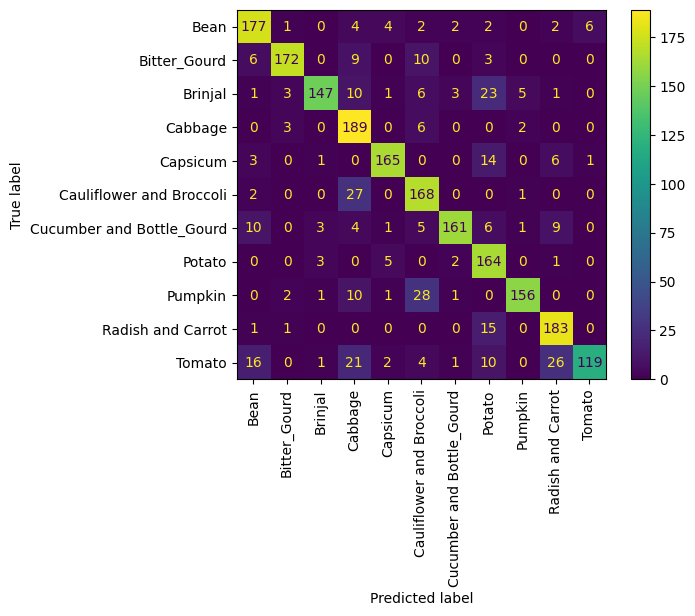

In [20]:

baseline_model_101 = create_baseline_model()
baseline_model_101.fit(
  X_train_101_augmented, y_train_101_augmented,
  epochs = 100,
  validation_data = (X_validation_101 , y_validation_101),
  verbose=1,
  batch_size=32,
  class_weight=class_weights_dict_101,
  callbacks=[F1ScoreCallback() ,EarlyStopping(patience=5, monitor='val_f1_score' , restore_best_weights=True, mode='max')]
)

y_pred = baseline_model_101.predict(X_test_101)
y_pred = np.argmax(y_pred , axis=1)
y_test = np.argmax(y_test_101, axis=1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

##### Creating Model

The Idea behind my model is going to be as follows:

1. Input Layer
2. Conv2d * **n** amounts
3. BatchNormalize
4. Activation Relu
5. Maxpooling/bottleneck layer
6. Flatten
7. Dense - softmax (we are doing multiclass-classification)

where layers 2-5 can be repeated **m** times.

For the Search, since i already have dedicated validation data, i will not be using kfold-cv.

##### Why normalization before Activation?

This is the **ResNet50 Architecture**

In [10]:
def create_model(n , m, 
            dropout, kernel_size, strides, padding, activation,
            kernel_regularization, activity_regularization,
            pooling_size
                 ):
  model = Sequential()

  # we want the neurons to be increasing, getting more complex further in
  neurons_arr = [32] # starting
  for _ in range(m -1 ):
    neurons_arr.append(neurons_arr[-1] *2)
  
  for i in range(m):
    # Adding n number of conv2d
    for _ in range(n):
      model.add(Conv2D(neurons_arr[i], kernel_size, strides=strides, padding=padding, kernel_regularizer=l2(kernel_regularization), activity_regularizer=l1(activity_regularization)))

    # Batch Norm before Activatoin follows the resnet50 architecture
    model.add(BatchNormalization())
    model.add(eval(f'{activation}()'))
    model.add(MaxPooling2D((pooling_size) , padding='same'))

  
  model.add(Dropout(dropout))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(128 , activation='relu'))
  model.add(Dropout(0.3)) # prevents overfitting from the previous dense layer
  model.add(Dense(11 , activation='softmax'))
  model.compile(loss='categorical_crossentropy' , optimizer=Adam(), metrics=[
    Precision(name='precision') , Recall(name='recall'), 'accuracy'
  ])
  return model
 
  


Note that tensor objects are not used in this param grid to ensure that it can be serialized and stored (using pickle) 



In [11]:
hyper_params = { 
  'n': np.arange(1 , 5),
  'm': np.arange(2 , 5),
  'dropout': np.arange(0.3 , 0.8 , 0.1),# 5
  'strides': [(1 , 1)],
  'padding': ['same'],
  'activation': ['ReLU' , 'LeakyReLU'],
  'kernel_size': [(3 , 3), (5 , 5)],
  'kernel_regularization': [0 , 1e-5 , 1e-6],
  'activity_regularization': [0 , 1e-6 , 1e-7],
  'pooling_size': [(2 ,2 ) , (3 ,3)]
}
batch_sizes = [32 , 64 , 128] 
val_losses = []
val_accuracies = []
val_recalls = []
fit_results = []
successful_params = []


##### Tuning for 23x23

In [27]:
random_samples = random.sample(list(ParameterGrid(hyper_params)), 25)
# Random Search
for params in random_samples:
  for batch_size in batch_sizes:
    try:
      K.clear_session() # save gpu memory
      print(f'Tuning for {params}... \nbatch size {batch_size}')

      # Create and fit
      model = create_model(**params)
      early_stop = EarlyStopping(monitor='val_f1_score' , patience=10 , restore_best_weights=True, mode='max')
      fit_result = model.fit(
                X_train_23_augmented, y_train_23_augmented, epochs=100 , 
                batch_size=batch_size, 
                validation_data=(X_validation_23, y_validation_23) ,
                class_weight=class_weights_dict_23
                , callbacks=[F1ScoreCallback() , early_stop]
                ,verbose = 0
                )

      # Eval and store 
      # will not be using cross val score since we have dedicated vaildation data.
      val_loss , val_precision ,val_recall, val_accuracy= model.evaluate(X_validation_23 , y_validation_23)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_recalls.append(val_recall)
      fit_results.append(fit_result.history)
      successful_params.append(dict(params , **{'batch_size': batch_size})) # this is required since im skipping bad params

      print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}, val recall: {val_recall}')
      print(f'Val precision: {val_precision} , val f1: {2 * ((val_precision * val_recall) / (val_precision + val_recall + K.epsilon()))}')
    except Exception as error:
      # handles any bad params configurations
      print('Error occured with this param configuration')
      print(error)
      continue
K.clear_session()

Tuning for {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.7000000000000002, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 4, 'n': 1, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1)}... 
batch size 32
69/69 [==============================] - 0s 5ms/step - loss: 0.9646 - precision: 0.7881 - recall: 0.6932 - accuracy: 0.7314
Val loss: 0.9645611047744751 , val_accuracy: 0.7313636541366577, val recall: 0.6931818127632141
Val precision: 0.7881137132644653 , val f1: 0.7376057592085292
Tuning for {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.7000000000000002, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 4, 'n': 1, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1)}... 
batch size 64
69/69 [==============================] - 0s 5ms/step - loss: 1.2120 - precision: 0.7567 - recall: 0.7155 - accuracy: 0.7282
Val loss: 1.2120428085327148 , val_accuracy: 0.7281818389892578, val recall: 0.7154545187950134
Val precision

In [28]:
validation_f1 = [np.max(res['val_f1_score']) for res in fit_results]

In [29]:
# Exporting 
results = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'validation_f1': validation_f1,
  'fit_results': fit_results
})

In [32]:
# attempt to pickle, if error just use .json format
with open(os.path.join('tuning_results' , '23_tuning_results_v4.pkl') , 'wb') as f:
  pickle.dump(results, f)

In [12]:
# Importing the results
results_23 = None

with open(os.path.join('tuning_results' , '23_tuning_results_v4.pkl') , 'rb') as f:
  results_23 = pickle.load(f)


##### Tuning for 101

In [25]:
# redefined
val_losses = []
val_accuracies = []
val_recalls = []
fit_results = []
successful_params = []

In [26]:
gc.collect()

35507

In [27]:
random_samples = random.sample(list(ParameterGrid(hyper_params)), 25)
# Random Search
for params in random_samples:
  for batch_size in [32 , 64]:
    try:
      K.clear_session() # save gpu memory
      print(f'Tuning for {params}... \nbatch size {batch_size}')

      # Create and fit
      model = create_model(**params)
      early_stop = EarlyStopping(monitor='val_f1_score' , patience=10 , restore_best_weights=True, mode='max')
      fit_result = model.fit(
                X_train_101_augmented, y_train_101_augmented, epochs=100 , 
                batch_size=batch_size, 
                validation_data=(X_validation_101, y_validation_101) ,
                class_weight=class_weights_dict_101
                , callbacks=[F1ScoreCallback() , early_stop]
                ,verbose = 0
                )

      # Eval and store 
      # will not be using cross val score since we have dedicated vaildation data.
      val_loss , val_precision ,val_recall, val_accuracy= model.evaluate(X_validation_101 , y_validation_101)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_recalls.append(val_recall)
      fit_results.append(fit_result.history)
      successful_params.append(dict(params , **{'batch_size': batch_size})) # this is required since im skipping bad params

      print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}, val recall: {val_recall}')
      print(f'Val precision: {val_precision} , val f1: {2 * ((val_precision * val_recall) / (val_precision + val_recall + K.epsilon()))}')

      # 101 takes alot of space so i need to clear up my vram
      del model
    except Exception as error:
      # handles any bad params configurations
      print('Error occured with this param configuration')
      print(error)
      # we assume that the error is from overloaded memory
      gc.collect()
      break
K.clear_session()

Tuning for {'activation': 'LeakyReLU', 'activity_regularization': 0, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1)}... 
batch size 32
68/68 [==============================] - 2s 33ms/step - loss: 1.7228 - precision: 0.5793 - recall: 0.4510 - accuracy: 0.5037
Val loss: 1.7227962017059326 , val_accuracy: 0.5037002563476562, val recall: 0.4509713351726532
Val precision: 0.5793226361274719 , val f1: 0.5071521034387134
Tuning for {'activation': 'LeakyReLU', 'activity_regularization': 0, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1)}... 
batch size 64
68/68 [==============================] - 2s 32ms/step - loss: 1.2839 - precision: 0.6582 - recall: 0.5888 - accuracy: 0.6253
Val loss: 1.2838726043701172 , val_accuracy: 0.6253468990325928, val recall: 0.588806688785553
Val precision: 0.6582213

In [28]:
validation_f1 = [np.max(res['val_f1_score']) for res in fit_results]

In [30]:
# Exporting 
results_101 = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'validation_f1': validation_f1,
  'fit_results': fit_results
})

In [31]:
# attempt to pickle, if error just use .json format
with open(os.path.join('tuning_results' , '101_tuning_results_v4.pkl') , 'wb') as f:
  pickle.dump(results_101, f)

In [13]:
# Importing the results
results_101 = None

with open(os.path.join('tuning_results' , '101_tuning_results_v4.pkl') , 'rb') as f:
  results_101 = pickle.load(f)

##### Evaluating and choosing params

In [21]:

# Deconstructing Results

val_accuracies_23 = results_23['validation_accuracies']
val_losses_23 = results_23['validation_losses']
val_f1_23 = results_23['validation_f1']
successful_params_23 = results_23['params']
fit_results_23 = results_23['fit_results']
                   
val_accuracies_101 = results_101['validation_accuracies']
val_losses_101 = results_101['validation_losses']
val_f1_101 = results_101['validation_f1']
successful_params_101 = results_101['params']
fit_results_101 = results_101['fit_results']

##### Best Model Analysis

In [23]:
best_index_23 = np.argmax(val_f1_23)
best_index_101 = np.argmax(val_f1_101)

In [24]:
print(f'Best_params 23: {successful_params_23[best_index_23]}')
print(f'Best_f1 23: {val_f1_23[best_index_23]}')
print(f'Best_params 101: {successful_params_101[best_index_101]}')
print(f'Best_f1 101: {val_f1_101[best_index_101]}')

Best_params 23: {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-05, 'kernel_size': (5, 5), 'm': 3, 'n': 2, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 32}
Best_f1 23: 0.8850205628651956
Best_params 101: {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 64}
Best_f1 101: 0.9517819271713465


##### Learning Rate Tuning for Adam

So i actually forgot to tune the learning rate initially, so i will do it seperately

This may overall affect my performance _(unable to achieve the 'best' model)_ but it's the best i can do due to time contraints _(im not tuning for another 13 hours)_

In [25]:
learning_rates = [1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3]


# we also need to modify the function to accept a learning rate
def create_model(n , m, 
            dropout, kernel_size, strides, padding, activation,
            kernel_regularization, activity_regularization,
            pooling_size, 
            learning_rate # added lr
                 ):
  model = Sequential()

  # we want the neurons to be increasing, getting more complex further in
  neurons_arr = [32] # starting
  for _ in range(m -1 ):
    neurons_arr.append(neurons_arr[-1] *2)
  
  for i in range(m):
    # Adding n number of conv2d
    for _ in range(n):
      model.add(Conv2D(neurons_arr[i], kernel_size, strides=strides, padding=padding, kernel_regularizer=l2(kernel_regularization), activity_regularizer=l1(activity_regularization)))

    # Batch Norm before Activatoin follows the resnet50 architecture
    model.add(BatchNormalization())
    model.add(eval(f'{activation}()'))
    model.add(MaxPooling2D((pooling_size) , padding='same'))

  
  model.add(Dropout(dropout))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(128 , activation='relu'))
  model.add(Dropout(0.3)) # prevents overfitting from the previous dense layer
  model.add(Dense(11 , activation='softmax'))
  model.compile(loss='categorical_crossentropy' , optimizer=Adam(learning_rate=learning_rate), metrics=[
    Precision(name='precision') , Recall(name='recall'), 'accuracy'
  ])
  return model
 

Tuning on lr 1e-05
69/69 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       200
           1       0.80      0.88      0.84       200
           2       0.74      0.80      0.77       200
           3       0.67      0.78      0.72       200
           4       0.94      0.77      0.85       200
           5       0.71      0.61      0.66       200
           6       0.83      0.68      0.74       200
           7       0.69      0.91      0.78       200
           8       0.78      0.70      0.74       200
           9       0.85      0.74      0.79       200
          10       0.67      0.80      0.73       200

    accuracy                           0.76      2200
   macro avg       0.77      0.76      0.76      2200
weighted avg       0.77      0.76      0.76      2200



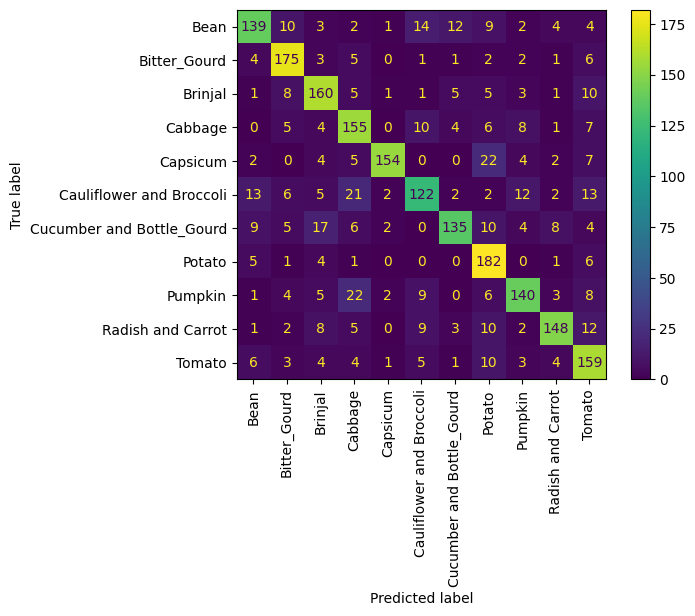

Tuning on lr 3e-05
69/69 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       200
           1       0.73      0.89      0.80       200
           2       0.87      0.72      0.79       200
           3       0.79      0.58      0.67       200
           4       0.74      0.92      0.82       200
           5       0.74      0.47      0.58       200
           6       0.75      0.72      0.74       200
           7       0.85      0.80      0.82       200
           8       0.56      0.92      0.69       200
           9       0.90      0.69      0.78       200
          10       0.74      0.71      0.73       200

    accuracy                           0.75      2200
   macro avg       0.77      0.75      0.75      2200
weighted avg       0.77      0.75      0.75      2200



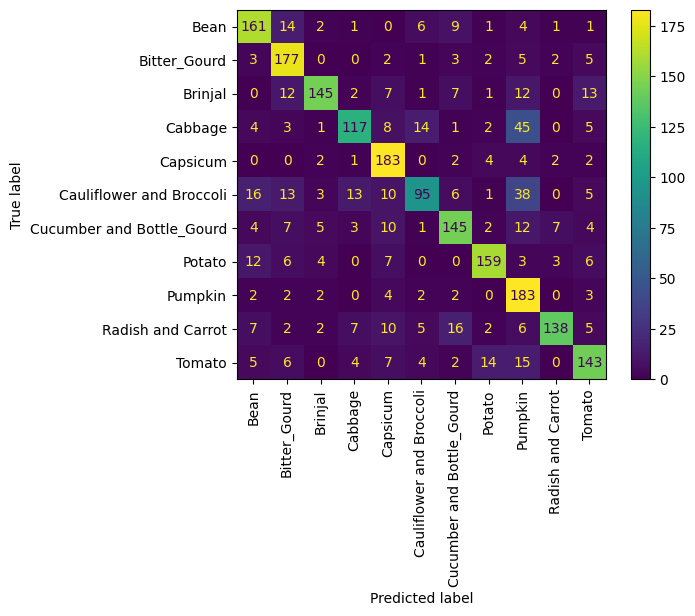

Tuning on lr 0.0001
69/69 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       200
           1       0.91      0.87      0.89       200
           2       0.72      0.94      0.81       200
           3       0.68      0.83      0.75       200
           4       0.96      0.70      0.81       200
           5       0.70      0.76      0.73       200
           6       0.96      0.64      0.77       200
           7       0.88      0.81      0.84       200
           8       0.79      0.84      0.81       200
           9       0.93      0.71      0.81       200
          10       0.65      0.89      0.75       200

    accuracy                           0.80      2200
   macro avg       0.82      0.80      0.80      2200
weighted avg       0.82      0.80      0.80      2200



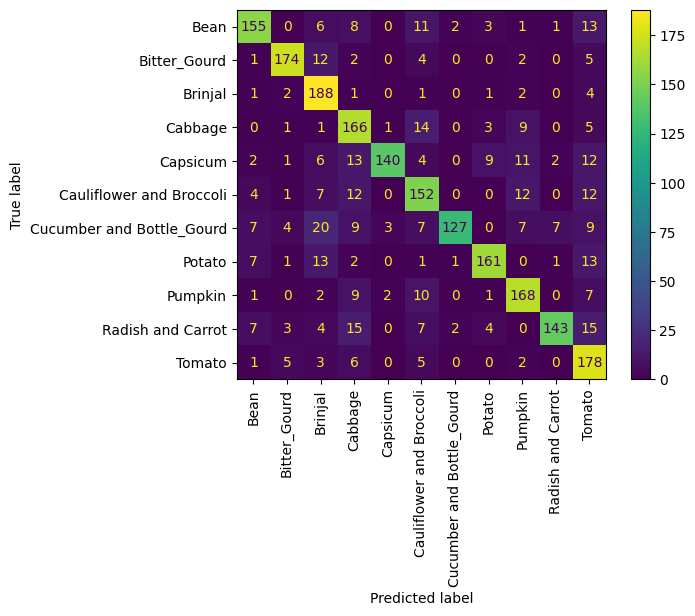

Tuning on lr 0.0003
69/69 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       200
           1       0.90      0.92      0.91       200
           2       0.73      0.94      0.82       200
           3       0.77      0.79      0.78       200
           4       0.87      0.92      0.89       200
           5       0.55      0.91      0.68       200
           6       0.91      0.82      0.86       200
           7       0.93      0.77      0.84       200
           8       0.96      0.65      0.77       200
           9       0.81      0.93      0.86       200
          10       0.94      0.63      0.75       200

    accuracy                           0.81      2200
   macro avg       0.84      0.81      0.81      2200
weighted avg       0.84      0.81      0.81      2200



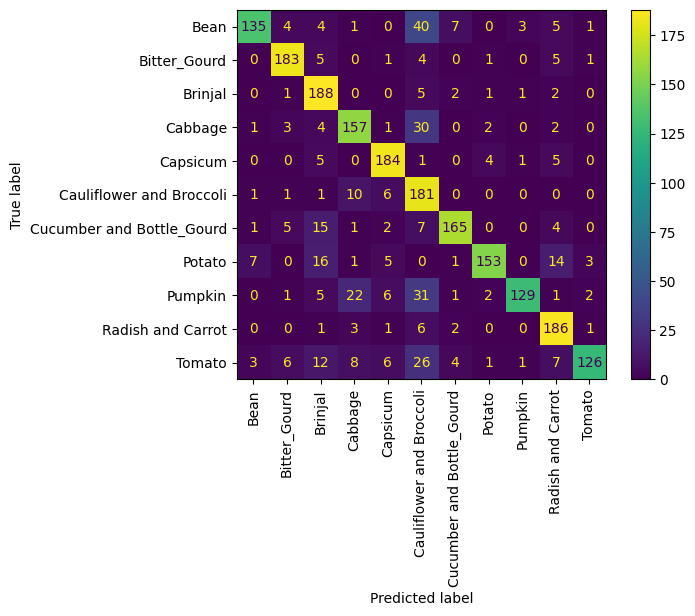

Tuning on lr 0.0005
69/69 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       200
           1       0.93      0.92      0.93       200
           2       0.84      0.78      0.81       200
           3       0.84      0.81      0.83       200
           4       0.96      0.81      0.88       200
           5       0.79      0.79      0.79       200
           6       0.71      0.94      0.81       200
           7       0.96      0.83      0.89       200
           8       0.77      0.85      0.81       200
           9       0.96      0.86      0.91       200
          10       0.77      0.90      0.83       200

    accuracy                           0.85      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.86      0.85      0.85      2200



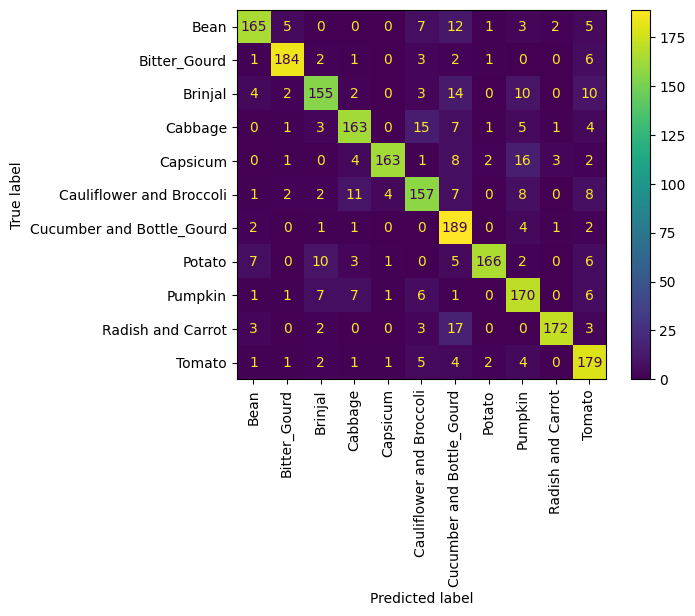

Tuning on lr 0.001
69/69 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       200
           1       0.88      0.94      0.91       200
           2       0.85      0.90      0.88       200
           3       0.69      0.88      0.78       200
           4       0.95      0.86      0.91       200
           5       0.69      0.84      0.76       200
           6       0.95      0.80      0.86       200
           7       0.96      0.71      0.82       200
           8       0.87      0.79      0.83       200
           9       0.88      0.92      0.90       200
          10       0.85      0.84      0.85       200

    accuracy                           0.85      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.86      0.85      0.85      2200



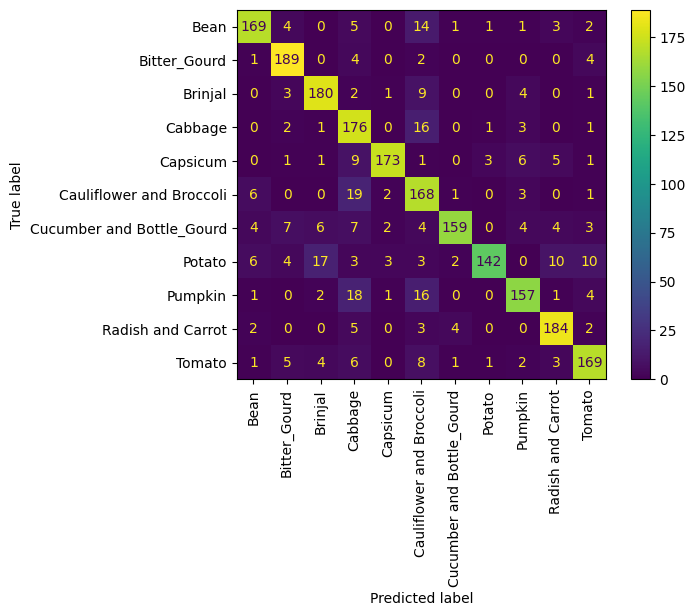

Tuning on lr 0.003
69/69 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       200
           1       0.90      0.94      0.92       200
           2       0.89      0.96      0.92       200
           3       0.82      0.78      0.80       200
           4       0.95      0.91      0.93       200
           5       0.79      0.78      0.78       200
           6       0.84      0.92      0.88       200
           7       0.87      0.91      0.89       200
           8       0.89      0.73      0.81       200
           9       0.93      0.87      0.90       200
          10       0.82      0.92      0.86       200

    accuracy                           0.87      2200
   macro avg       0.87      0.87      0.87      2200
weighted avg       0.87      0.87      0.87      2200



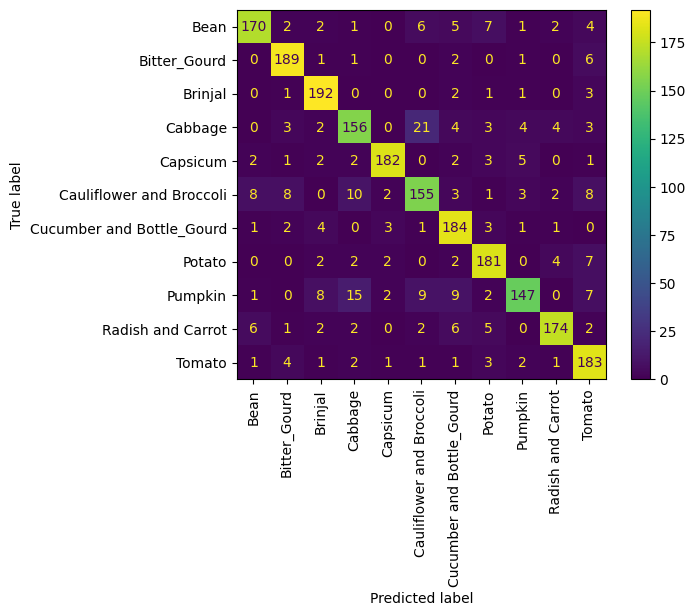

In [38]:
# 23
for lr in learning_rates:
  params = successful_params_23[best_index_23]
  print(f'Tuning on lr {lr}')

  # Creating Model
  model = create_model(**{k:v for k , v in params.items() if k != 'batch_size'}, learning_rate=lr)
  early_stop = EarlyStopping(monitor='val_f1_score' , patience=10 , restore_best_weights=True, mode='max')
  fit_result = model.fit(
            X_train_23_augmented, y_train_23_augmented, epochs=100 , 
            batch_size=params['batch_size'], 
            validation_data=(X_validation_23, y_validation_23) ,
            class_weight=class_weights_dict_23
            , callbacks=[F1ScoreCallback() , early_stop]
            ,verbose = 0
            )

  ## results
  y_pred = np.argmax(model.predict(X_validation_23) , axis = 1)
  y_test = np.argmax(y_test_23, axis=1)
  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
  disp.plot()
  plt.xticks(rotation=90)
  plt.show()

For 23x23, in terms of f1 performance, it seems that the best lr is 0.003

In [16]:
gc.collect() 

644

Tuning on lr 1e-05
68/68 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       200
           1       0.97      0.94      0.95       200
           2       0.91      0.90      0.91       200
           3       0.94      0.85      0.90       200
           4       0.91      0.95      0.93       190
           5       0.82      0.92      0.87       198
           6       0.93      0.86      0.90       200
           7       0.94      0.91      0.92       175
           8       0.92      0.95      0.93       199
           9       0.99      0.88      0.93       200
          10       0.86      0.98      0.92       200

    accuracy                           0.92      2162
   macro avg       0.92      0.92      0.92      2162
weighted avg       0.92      0.92      0.92      2162



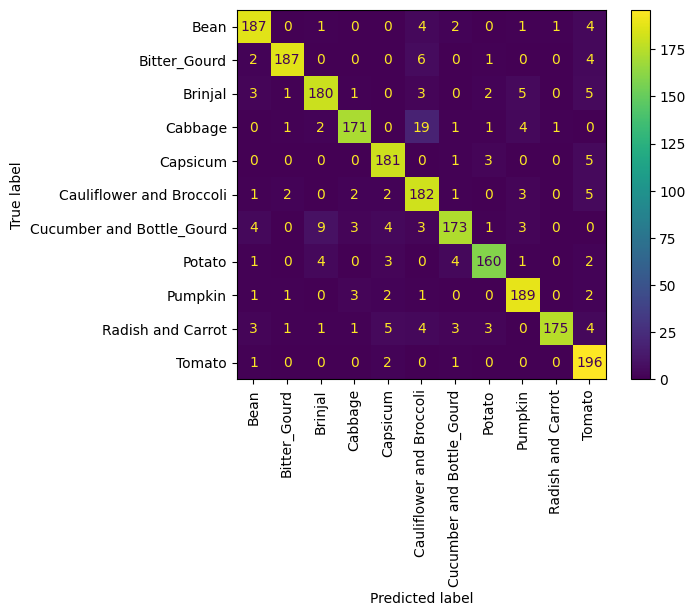

Tuning on lr 3e-05
68/68 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       200
           1       0.97      0.92      0.94       200
           2       0.99      0.87      0.93       200
           3       0.91      0.90      0.91       200
           4       0.93      0.94      0.93       190
           5       0.93      0.83      0.88       198
           6       0.82      0.97      0.89       200
           7       0.86      0.95      0.90       175
           8       0.92      0.93      0.92       199
           9       0.92      0.96      0.94       200
          10       0.90      0.90      0.90       200

    accuracy                           0.92      2162
   macro avg       0.92      0.92      0.92      2162
weighted avg       0.92      0.92      0.92      2162



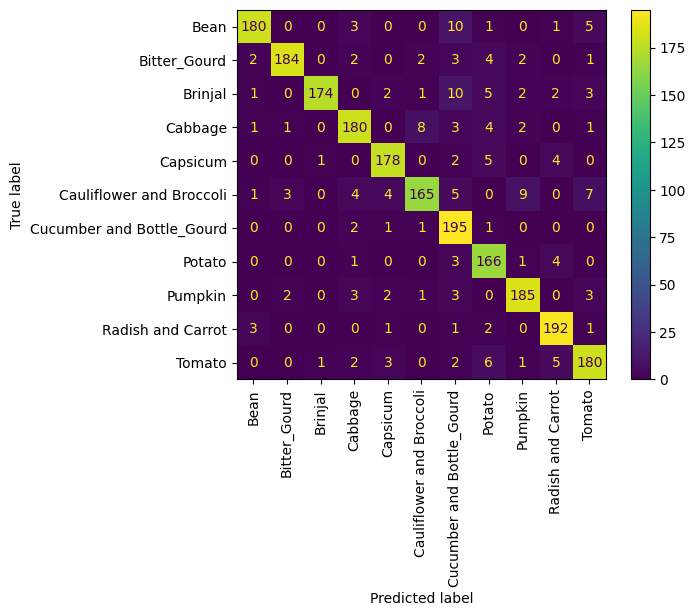

Tuning on lr 0.0001
68/68 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       200
           1       0.97      0.88      0.92       200
           2       0.97      0.82      0.89       200
           3       0.92      0.90      0.91       200
           4       0.76      0.97      0.85       190
           5       0.87      0.84      0.85       198
           6       0.99      0.80      0.88       200
           7       0.85      0.94      0.89       175
           8       0.90      0.91      0.91       199
           9       0.98      0.86      0.92       200
          10       0.78      0.99      0.87       200

    accuracy                           0.89      2162
   macro avg       0.90      0.89      0.89      2162
weighted avg       0.90      0.89      0.89      2162



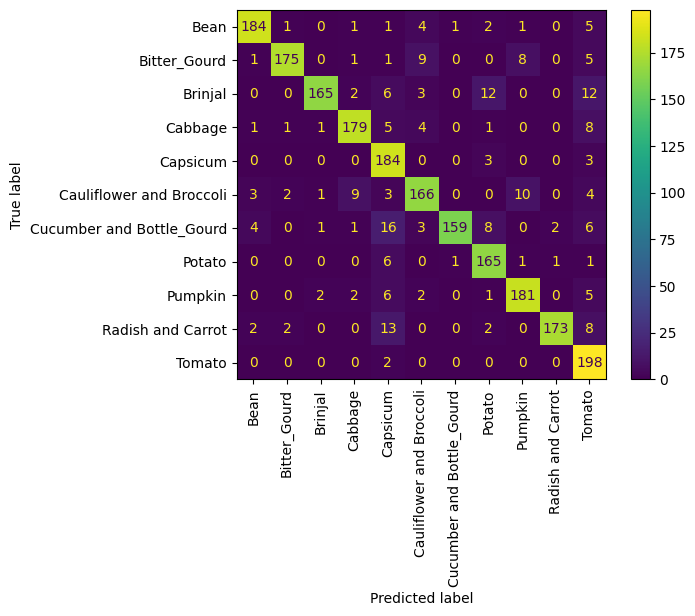

Tuning on lr 0.0003
68/68 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       200
           1       0.84      0.97      0.90       200
           2       0.99      0.83      0.90       200
           3       0.97      0.88      0.92       200
           4       0.94      0.96      0.95       190
           5       0.98      0.72      0.83       198
           6       0.84      0.96      0.90       200
           7       0.87      0.92      0.89       175
           8       0.80      0.96      0.88       199
           9       0.89      0.96      0.93       200
          10       0.98      0.85      0.91       200

    accuracy                           0.91      2162
   macro avg       0.91      0.91      0.91      2162
weighted avg       0.91      0.91      0.91      2162



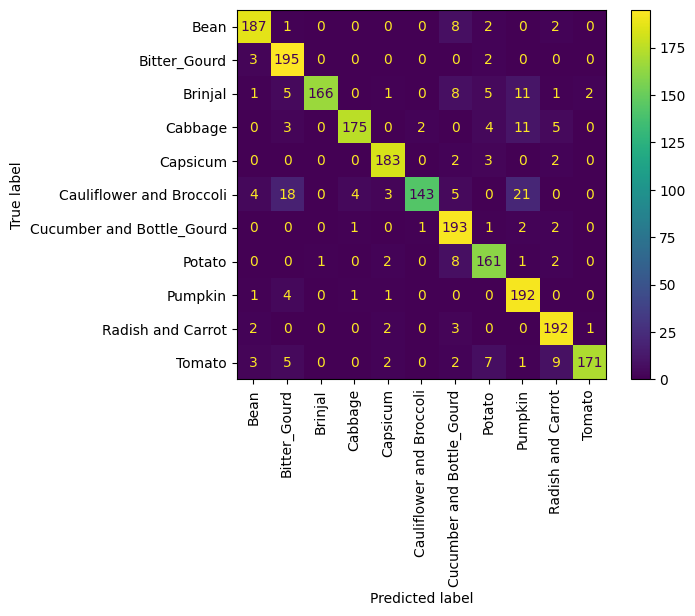

Tuning on lr 0.0005
68/68 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       200
           1       0.96      0.96      0.96       200
           2       0.90      0.95      0.92       200
           3       0.99      0.83      0.90       200
           4       0.97      0.91      0.94       190
           5       0.73      0.95      0.83       198
           6       0.87      0.91      0.89       200
           7       0.98      0.94      0.96       175
           8       0.95      0.92      0.94       199
           9       0.98      0.93      0.95       200
          10       0.83      0.95      0.89       200

    accuracy                           0.91      2162
   macro avg       0.92      0.91      0.91      2162
weighted avg       0.92      0.91      0.91      2162



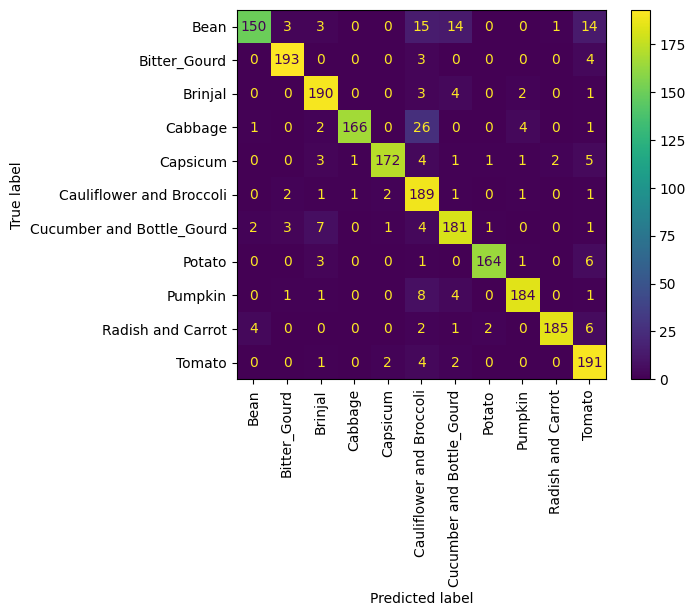

Tuning on lr 0.001
68/68 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       200
           1       0.89      0.93      0.91       200
           2       0.90      0.91      0.90       200
           3       0.97      0.79      0.87       200
           4       0.89      0.97      0.93       190
           5       0.76      0.93      0.84       198
           6       0.89      0.91      0.90       200
           7       0.94      0.85      0.89       175
           8       0.95      0.84      0.90       199
           9       0.99      0.95      0.97       200
          10       0.82      0.96      0.89       200

    accuracy                           0.90      2162
   macro avg       0.91      0.90      0.90      2162
weighted avg       0.91      0.90      0.90      2162



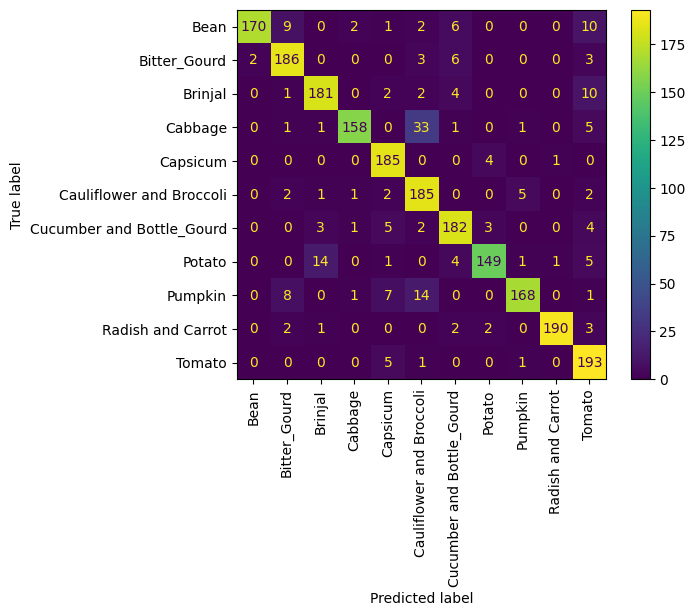

Tuning on lr 0.003
68/68 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       200
           1       0.81      0.98      0.89       200
           2       0.98      0.67      0.80       200
           3       0.87      0.91      0.89       200
           4       0.68      0.98      0.80       190
           5       0.94      0.74      0.83       198
           6       0.82      0.82      0.82       200
           7       0.95      0.83      0.89       175
           8       0.75      0.90      0.82       199
           9       0.89      0.88      0.89       200
          10       0.99      0.77      0.86       200

    accuracy                           0.85      2162
   macro avg       0.87      0.85      0.85      2162
weighted avg       0.87      0.85      0.85      2162



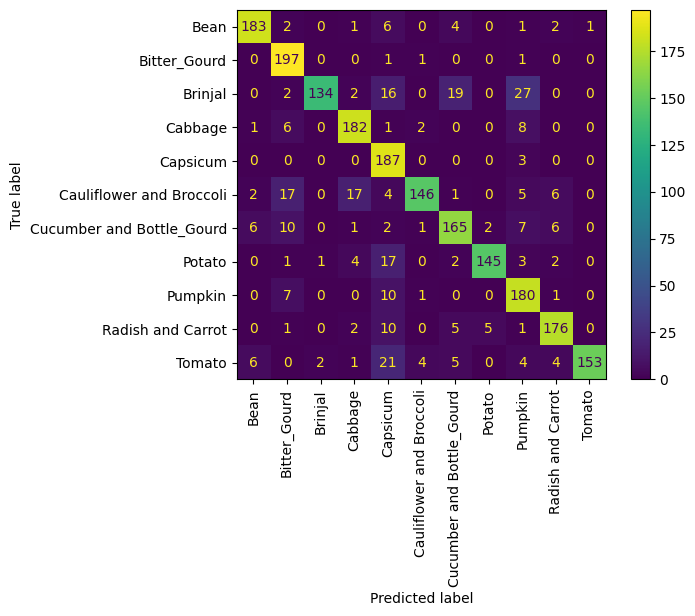

In [31]:
# 101
for lr in learning_rates:
  try:
    params = successful_params_101[best_index_101]
    print(f'Tuning on lr {lr}')

    # handle memory
    gc.collect()

    # Creating Model
    model = create_model(**{k:v for k , v in params.items() if k != 'batch_size'}, learning_rate=lr)
    early_stop = EarlyStopping(monitor='val_f1_score' , patience=10 , restore_best_weights=True, mode='max')
    fit_result = model.fit(
              X_train_101_augmented, y_train_101_augmented, epochs=100 , 
              batch_size=params['batch_size'], 
              validation_data=(X_validation_101, y_validation_101) ,
              class_weight=class_weights_dict_101
              , callbacks=[F1ScoreCallback() , early_stop]
              ,verbose = 0
              )

    ## results
    y_pred = np.argmax(model.predict(X_validation_101) , axis = 1)
    y_test = np.argmax(y_test_101, axis=1)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
    disp.plot()
    plt.xticks(rotation=90)
    plt.show()
  except Exception as e:
    print(e)
    print('error with this size')
    gc.collect()

For now i want to look at the loss and learning rates

Mainly i want to see if my model is overfitting or underfitting

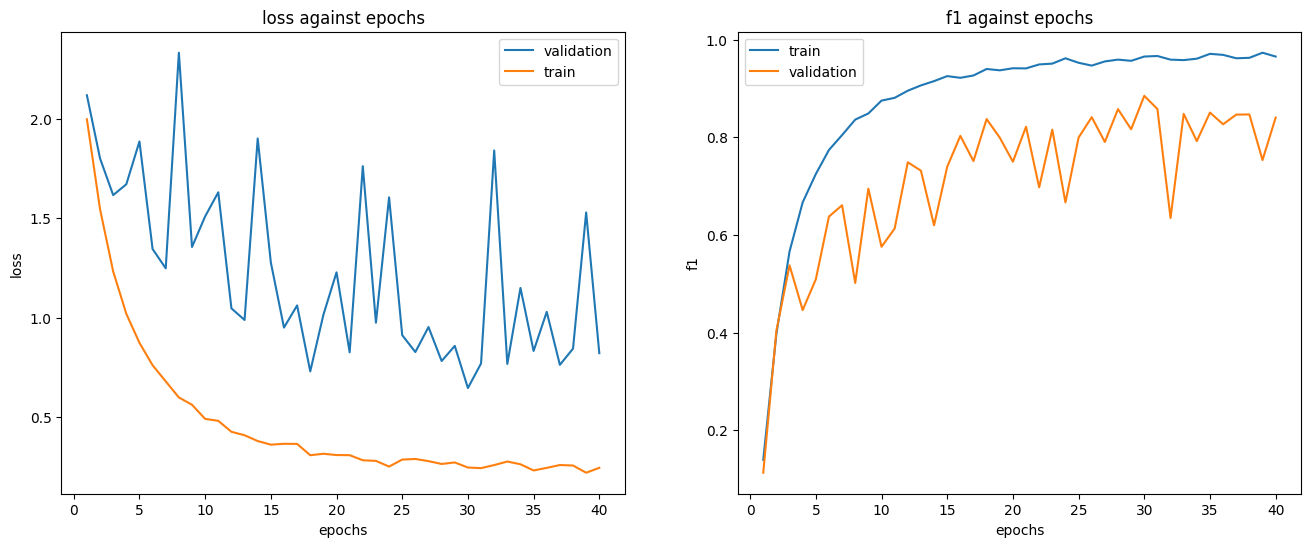

In [ ]:
fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))
epochs = range(1, len(fit_results_23[best_index_23]['val_loss']) + 1)

# loss
ax[0].plot(epochs , fit_results_23[best_index_23]['val_loss'], label='validation')
ax[0].plot(epochs , fit_results_23[best_index_23]['loss'] , label='train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('loss against epochs')

# acc
ax[1].plot(epochs , fit_results_23[best_index_23]['f1_score'] , label='train')
ax[1].plot(epochs , fit_results_23[best_index_23]['val_f1_score'], label='validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('f1')
ax[1].set_title('f1 against epochs')
plt.show()


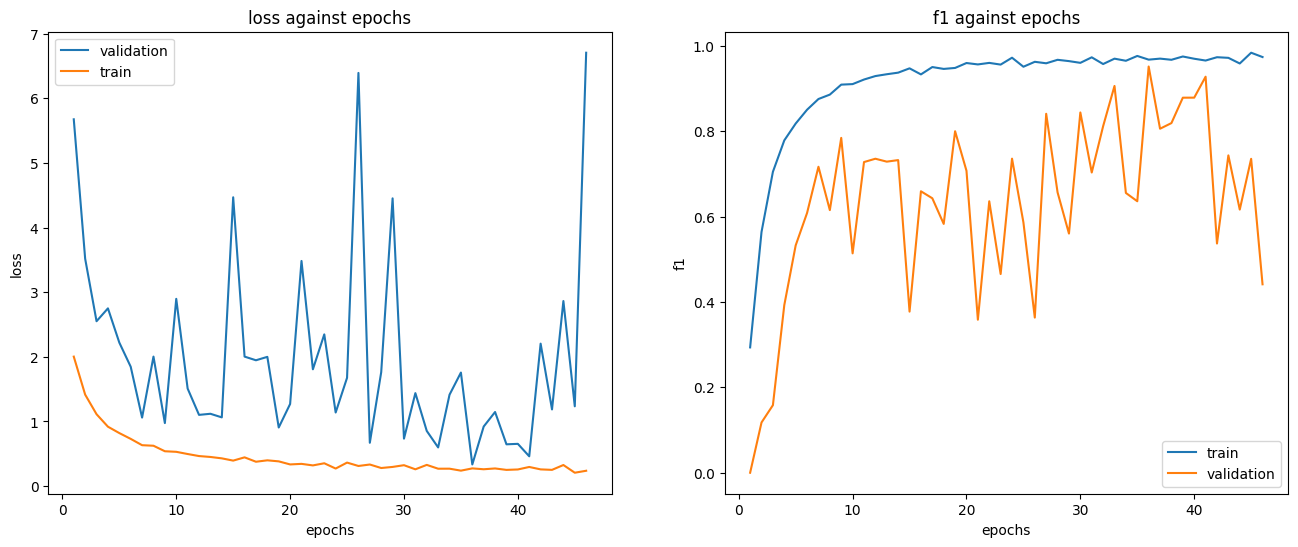

In [ ]:
fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))
epochs = range(1, len(fit_results_101[best_index_101]['val_loss']) + 1)

# loss
ax[0].plot(epochs , fit_results_101[best_index_101]['val_loss'], label='validation')
ax[0].plot(epochs , fit_results_101[best_index_101]['loss'] , label='train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('loss against epochs')

# acc
ax[1].plot(epochs , fit_results_101[best_index_101]['f1_score'] , label='train')
ax[1].plot(epochs , fit_results_101[best_index_101]['val_f1_score'], label='validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('f1')
ax[1].set_title('f1 against epochs')
plt.show()


##### Making Predictions

The results suggests that using all the training data is optimal for this problem

I want to try the top 2 models and compare them against each other

##### Choice of Epochs

I will use early stop with patience 3. 

With **restore_best_weights**, it should be able to capture the point **right before overfitting**

Though if i feel like it is unable to i will analyse the graph further and manually set the epoch

In [28]:
params_to_consider = [best_index_23 , best_index_101]

Testing {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-05, 'kernel_size': (5, 5), 'm': 3, 'n': 2, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 32}
Epoch 1/50
289/289 [==============================] - 6s 14ms/step - loss: 2.0100 - precision: 0.5124 - recall: 0.0671 - accuracy: 0.3133 - val_loss: 2.0511 - val_precision: 0.6970 - val_recall: 0.0523 - val_accuracy: 0.3214 - f1_score: 0.1186 - val_f1_score: 0.0973
Epoch 2/50
289/289 [==============================] - 3s 12ms/step - loss: 1.5731 - precision: 0.6962 - recall: 0.2714 - accuracy: 0.4917 - val_loss: 2.8257 - val_precision: 0.3952 - val_recall: 0.2595 - val_accuracy: 0.3127 - f1_score: 0.3905 - val_f1_score: 0.3133
Epoch 3/50
289/289 [==============================] - 4s 12ms/step - loss: 1.3156 - precision: 0.7421 - recall: 0.4196 - accuracy: 0.5909 - val_loss: 3.3735 - val_precision: 0.3423 - val_recall: 0.2950 - val_accuracy: 0.3145 - f1_scor

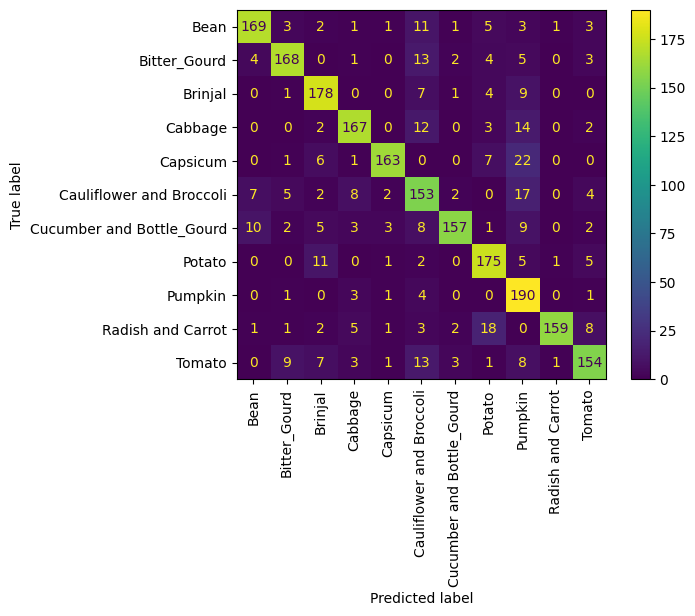

In [30]:
params = successful_params_23[best_index_23] 
print(f'Testing {successful_params_23[best_index_23]}')
model_params = {k:v for k , v in params.items() if k != 'batch_size'}
# callbacks
early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_params_size_23_v4.h5'),
                                    monitor='val_f1_score',
                                    save_best_only=True,
                                    save_weight_only=True,                                    
                                    mode='max'
                                   )
# fitting
model = create_model(**model_params)
results = model.fit(X_train_23_augmented, y_train_23_augmented,
                    epochs=50,
                    batch_size=params['batch_size'],
                    callbacks=[F1ScoreCallback() , early_stopper , model_checkpoint],
                    validation_data = (X_validation_23, y_validation_23),
                    class_weight=class_weights_dict_23,
                    verbose=1
                    )
epochs = len(results.history['loss'])
# predict
y_pred = model.predict(X_test_23)
y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

## results
y_test_labels = np.argmax(y_test_23, axis=1)
print(classification_report(y_test_labels , y_pred))
cm = confusion_matrix(y_test_labels , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

### 101 x 101

Now i can do the exact same steps for 101x101 size

Testing {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 64}
Epoch 1/50
143/143 [==============================] - 24s 146ms/step - loss: 2.0467 - precision: 0.6381 - recall: 0.1728 - accuracy: 0.3782 - val_loss: 4.1997 - val_precision: 0.0930 - val_recall: 0.0925 - val_accuracy: 0.0925 - f1_score: 0.2719 - val_f1_score: 0.0928
Epoch 2/50
143/143 [==============================] - 20s 139ms/step - loss: 1.3783 - precision: 0.7514 - recall: 0.4721 - accuracy: 0.6217 - val_loss: 5.8273 - val_precision: 0.1854 - val_recall: 0.0902 - val_accuracy: 0.1203 - f1_score: 0.5799 - val_f1_score: 0.1213
Epoch 3/50
143/143 [==============================] - 20s 137ms/step - loss: 1.0910 - precision: 0.8215 - recall: 0.6376 - accuracy: 0.7251 - val_loss: 4.2078 - val_precision: 0.1002 - val_recall: 0.0897 - val_accuracy: 0.0897 - f

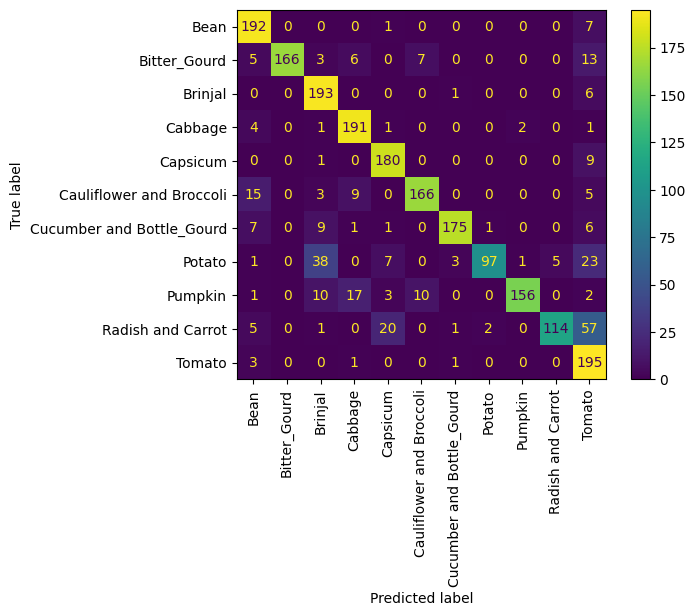

In [31]:
params = successful_params_101[best_index_101] 
print(f'Testing {successful_params_101[best_index_101]}')
model_params = {k:v for k , v in params.items() if k != 'batch_size'}
# callbacks
early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_params_size_101_v4.h5'),
                                    monitor='val_f1_score',
                                    save_best_only=True,
                                    save_weight_only=True,                                    
                                    mode='max'
                                   )
# fitting
model = create_model(**model_params)
results = model.fit(X_train_101_augmented, y_train_101_augmented,
                    epochs=50,
                    batch_size=params['batch_size'],
                    callbacks=[F1ScoreCallback() , early_stopper , model_checkpoint],
                    validation_data = (X_validation_101, y_validation_101),
                    class_weight=class_weights_dict_101,
                    verbose=1
                    )
# predict
y_pred = model.predict(X_test_101)
y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

## results
y_test_labels = np.argmax(y_test_101, axis=1)
print(classification_report(y_test_labels , y_pred))
cm = confusion_matrix(y_test_labels , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

##### Evaluating Results